<a href="https://colab.research.google.com/github/ucaokylong/Some_small_projects/blob/main/transformer_translation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pathlib
import tensorflow as tf
import shutil

# Download dataset provided by Anki
text_file = tf.keras.utils.get_file(
    fname="fra-eng.zip",
    origin="http://storage.googleapis.com/download.tensorflow.org/data/fra-eng.zip",
    extract=True
)

# Define the paths
extracted_file = pathlib.Path(text_file).parent / "fra.txt"
target_directory = pathlib.Path("/content/sample_data")
target_file = target_directory / "fra.txt"

# Create the target directory if it doesn't exist
target_directory.mkdir(parents=True, exist_ok=True)

# Move the file to the target directory
shutil.move(str(extracted_file), str(target_file))

# Print the new location of the file
print(target_file)

3423204/3423204 [==============================] - 0s 0us/step
/content/sample_data/fra.txt


In [ ]:
shutil.move(str(target_file), str("/content/fra.txt"))

'/content/fra.txt'

In [ ]:
import pathlib
import pickle
import random
import re
import unicodedata
import tensorflow as tf


def normalize(line):
  """Normalize a line of text and split into two at the tab character"""
  line = unicodedata.normalize("NFKC", line.strip().lower())
  line = re.sub(r"^([^ \w])(?!\s)", r"\1 ", line)
  line = re.sub(r"(\s[^ \w])(?!\s)", r"\1 ", line)
  line = re.sub(r"(?!\s)([^ \w])$", r" \1", line)
  line = re.sub(r"(?!\s)([^ \w]\s)", r" \1", line)
  eng, fra = line.split("\t")
  fra = "[start] " + fra + " [end]"
  return eng, fra


# normalize each line and separate into English and French
with open(r"/content/fra.txt") as fp:
  text_pairs = [normalize(line) for line in fp]
# print some samples
for _ in range(5):
  print(random.choice(text_pairs))
with open("text_pairs.pickle", "wb") as fp:
  pickle.dump(text_pairs, fp)

('see you soon !', '[start] à bientôt  !  [end]')
('tom soon fell asleep and started snoring .', "[start] tom s'endormit rapidement et commença à ronfler . [end]")
('what you said does not apply to this case .', "[start] ce que vous dites ne s'applique pas dans ce cas . [end]")
("don't disappoint me the way you did the other day .", "[start] ne me déçois pas comme tu l'as fait l'autre jour . [end]")
("why don't i call you ?", "[start] pourquoi est-ce que je ne t'appelle pas  ?  [end]")


In [ ]:
import pickle
with open("text_pairs.pickle", "rb") as fp:
  text_pairs = pickle.load(fp)
# count tokens
eng_tokens, fra_tokens = set(), set()
eng_maxlen, fra_maxlen = 0, 0
for eng, fra in text_pairs:
  eng_tok, fra_tok = eng.split(), fra.split()
  eng_maxlen = max(eng_maxlen, len(eng_tok))
  fra_maxlen = max(fra_maxlen, len(fra_tok))
  eng_tokens.update(eng_tok)
  fra_tokens.update(fra_tok)
print(f"Total English tokens: {len(eng_tokens)}")
print(f"Total French tokens: {len(fra_tokens)}")
print(f"Max English length: {eng_maxlen}")
print(f"Max French length: {fra_maxlen}")
print(f"{len(text_pairs)} total pairs")


Total English tokens: 14969
Total French tokens: 29219
Max English length: 51
Max French length: 60
167130 total pairs


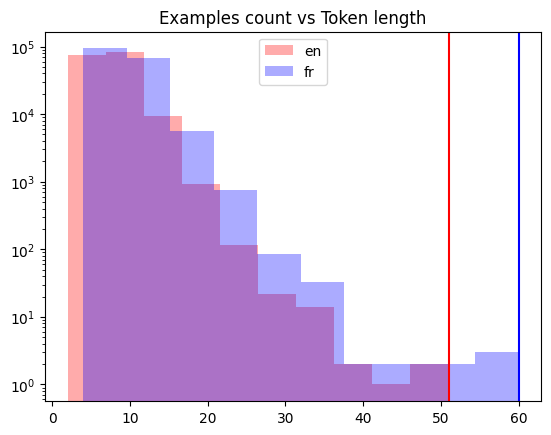

In [ ]:
import pickle
import matplotlib.pyplot as plt
with open("text_pairs.pickle", "rb") as fp:
  text_pairs = pickle.load(fp)
# histogram of sentence length in tokens
en_lengths = [len(eng.split()) for eng, fra in text_pairs]
fr_lengths = [len(fra.split()) for eng, fra in text_pairs]
plt.hist(en_lengths, label="en", color="red", alpha=0.33)
plt.hist(fr_lengths, label="fr", color="blue", alpha=0.33)
plt.yscale("log") # sentence length fits Benford"s law
plt.ylim(plt.ylim()) # make y-axis consistent for both plots
plt.plot([max(en_lengths), max(en_lengths)], plt.ylim(), color="red")
plt.plot([max(fr_lengths), max(fr_lengths)], plt.ylim(), color="blue")
plt.legend()
plt.title("Examples count vs Token length")
plt.show()


## Vectorization and Making Datasets


In [ ]:
import pickle
import random
from tensorflow.keras.layers import TextVectorization
# Load normalized sentence pairs
with open("text_pairs.pickle", "rb") as fp:
  text_pairs = pickle.load(fp)
# train-test-val split of randomized sentence pairs
random.shuffle(text_pairs)
n_val = int(0.15*len(text_pairs))
n_train = len(text_pairs) - 2*n_val
train_pairs = text_pairs[:n_train]
val_pairs = text_pairs[n_train:n_train+n_val]
test_pairs = text_pairs[n_train+n_val:]
# Parameter determined after analyzing the input data
vocab_size_en = 10000
vocab_size_fr = 20000
seq_length = 20
# Create vectorizer
eng_vectorizer = TextVectorization(
                                    max_tokens=vocab_size_en,
                                    standardize=None,
                                    split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=seq_length,
                                    )
fra_vectorizer = TextVectorization(
                                    max_tokens=vocab_size_fr,
                                    standardize=None,
                                    split="whitespace",
                                    output_mode="int",
                                    output_sequence_length=seq_length + 1
                                    )
# train the vectorization layer using training dataset
train_eng_texts = [pair[0] for pair in train_pairs]
train_fra_texts = [pair[1] for pair in train_pairs]
eng_vectorizer.adapt(train_eng_texts)
fra_vectorizer.adapt(train_fra_texts)
# save for subsequent steps
with open("vectorize.pickle", "wb") as fp:
  data = {
  "train": train_pairs,
  "val": val_pairs,
  "test": test_pairs,
  "engvec_config": eng_vectorizer.get_config(),
  "engvec_weights": eng_vectorizer.get_weights(),
  "fravec_config": fra_vectorizer.get_config(),
  "fravec_weights": fra_vectorizer.get_weights(),
  }
  pickle.dump(data, fp)

In [ ]:
import pickle
import tensorflow as tf

from tensorflow.keras.layers import TextVectorization
# load text data and vectorizer weights
with open("vectorize.pickle", "rb") as fp:
  data = pickle.load(fp)
train_pairs = data["train"]
val_pairs = data["val"]
test_pairs = data["test"] # not used
eng_vectorizer = TextVectorization.from_config(data["engvec_config"])
eng_vectorizer.set_weights(data["engvec_weights"])
fra_vectorizer = TextVectorization.from_config(data["fravec_config"])
fra_vectorizer.set_weights(data["fravec_weights"])
# set up Dataset object
def format_dataset(eng, fra):
  """Take an English and a French sentence pair, convert into input and target.
  The input is a dict with keys `encoder_inputs` and `decoder_inputs`, each
  is a vector, corresponding to English and French sentences respectively.
  The target is also vector of the French sentence, advanced by 1 token. All
  vector are in the same length.
  The output will be used for training the transformer model. In the model we
  will create, the input tensors are named `encoder_inputs` and `decoder_inputs`
  which should be matched to the keys in the dictionary for the source part
  """
  eng = eng_vectorizer(eng)
  fra = fra_vectorizer(fra)
  source = {"encoder_inputs": eng, "decoder_inputs": fra[:, :-1]}
  target = fra[:, 1:]
  return (source, target)

def make_dataset(pairs, batch_size=64):
  """Create TensorFlow Dataset for the sentence pairs"""
# aggregate sentences using zip(*pairs)
  eng_texts, fra_texts = zip(*pairs)
# convert them into list, and then create tensors
  dataset = tf.data.Dataset.from_tensor_slices((list(eng_texts), list(fra_texts)))
  return dataset.shuffle(2048) \
                .batch(batch_size).map(format_dataset) \
                .prefetch(16).cache()
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)
# test the dataset
for inputs, targets in train_ds.take(1):
  print(f'inputs["encoder_inputs"].shape: {inputs["encoder_inputs"].shape}')
  print(f'inputs["encoder_inputs"][0]: {inputs["encoder_inputs"][0]}')
  print(f'inputs["decoder_inputs"].shape: {inputs["decoder_inputs"].shape}')
  print(f'inputs["decoder_inputs"][0]: {inputs["decoder_inputs"][0]}')
  print(f"targets.shape: {targets.shape}")
  print(f"targets[0]: {targets[0]}")



inputs["encoder_inputs"].shape: (64, 20)
inputs["encoder_inputs"][0]: [  27  495  114    3 1555   25    7    0    0    0    0    0    0    0
    0    0    0    0    0    0]
inputs["decoder_inputs"].shape: (64, 20)
inputs["decoder_inputs"][0]: [   2  246    9    5   29 1285  532  502    7    3    0    0    0    0
    0    0    0    0    0    0]
targets.shape: (64, 20)
targets[0]: [ 246    9    5   29 1285  532  502    7    3    0    0    0    0    0
    0    0    0    0    0    0]


## Positional Encoding Matrix

When a sentence is vectorized, you get a vector of integers, where each integer represents a word. The integer here is only a label. We cannot assume two integers closer to each other means the words they represent are related.

In order to understand the meaning of words and hence quantify how two words are related to each other, you will use the technique word embeddings. But to understand the context, you also need to know the position of each word in a sentence. This is done by
positional encoding.

In the paper “Attention Is All You Need”, positional encoding represents each token position with a vector. The elements of the vector are values of the different phase and frequency of sine waves. Precisely, at position k = 0, 1, · · · , L − 1, the positional encoding
vector (of length d) is

[P(k, 0), P(k, 1), · · · , P(k, d − 2), P(k, d − 1)]

where for i = 0, 1, · · · , d/2,

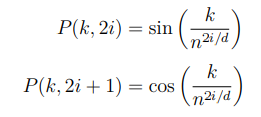

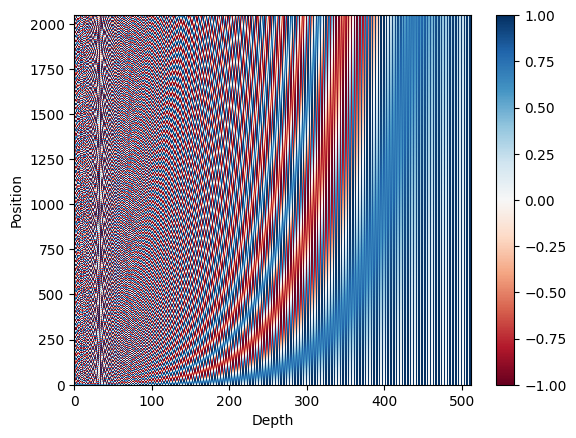

In [ ]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

def pos_enc_matrix(L, d, n=10000):
    """
    Create positional encoding matrix.

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d))
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d // 2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)  # L-column vector
    i = np.arange(d2).reshape(1, -1)  # d-row vector
    denom = np.power(n, -i / d2)  # n**(-2*i/d)
    args = k * denom  # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

# Plot the positional encoding matrix
pos_matrix = pos_enc_matrix(L=2048, d=512)
assert pos_matrix.shape == (2048, 512)

plt.pcolormesh(pos_matrix, cmap='RdBu')
plt.xlabel('Depth')
plt.ylabel('Position')
plt.colorbar()
plt.show()

# Save the positional encoding matrix to a file
with open("posenc-2048-512.pickle", "wb") as fp:
    pickle.dump(pos_matrix, fp)


#Positional Encoder Layer

The transformer model from the paper “Attention Is All You Need” is illustrated below:

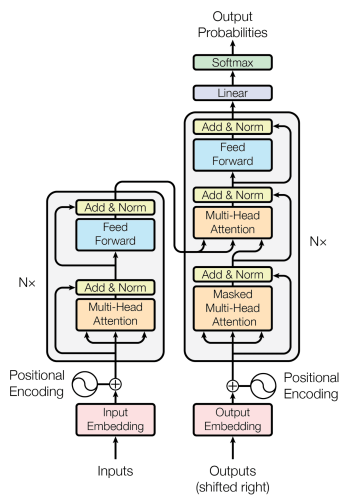

The positional encoding layer is at the entry point of a transformer model. However, the Keras library does not provide us one. You can create a custom layer to implement the positional encoding, as follows.

In [ ]:
import numpy as np
import tensorflow as tf

def pos_enc_matrix(L, d, n=10000):
    """
    Create positional encoding matrix.

    Args:
        L: Input dimension (length)
        d: Output dimension (depth), even only
        n: Constant for the sinusoidal functions

    Returns:
        numpy matrix of floats of dimension L-by-d. At element (k,2i) the value
        is sin(k/n^(2i/d)) while at element (k,2i+1) the value is cos(k/n^(2i/d)).
    """
    assert d % 2 == 0, "Output dimension needs to be an even integer"
    d2 = d // 2
    P = np.zeros((L, d))
    k = np.arange(L).reshape(-1, 1)  # L-column vector
    i = np.arange(d2).reshape(1, -1)  # d-row vector
    denom = np.power(n, -i / d2)  # n**(-2*i/d)
    args = k * denom  # (L,d) matrix
    P[:, ::2] = np.sin(args)
    P[:, 1::2] = np.cos(args)
    return P

class PositionalEmbedding(tf.keras.layers.Layer):
    """
    Positional embedding layer. Assume tokenized input, transform into
    embedding and returns positional-encoded output.
    """
    def __init__(self, sequence_length, vocab_size, embed_dim, **kwargs):
        """
        Args:
            sequence_length: Input sequence length
            vocab_size: Input vocab size, for setting up embedding matrix
            embed_dim: Embedding vector size, for setting up embedding matrix
        """
        super().__init__(**kwargs)
        self.sequence_length = sequence_length
        self.vocab_size = vocab_size
        self.embed_dim = embed_dim  # d_model in paper
        # token embedding layer: Convert integer token to D-dim float vector
        self.token_embeddings = tf.keras.layers.Embedding(
            input_dim=vocab_size, output_dim=embed_dim, mask_zero=True
        )
        # positional embedding layer: a matrix of hard-coded sine values
        matrix = pos_enc_matrix(sequence_length, embed_dim)
        self.position_embeddings = tf.constant(matrix, dtype="float32")

    def call(self, inputs):
        """
        Input tokens convert into embedding vectors then superimposed
        with position vectors.
        """
        embedded_tokens = self.token_embeddings(inputs)
        return embedded_tokens + self.position_embeddings

    def compute_mask(self, *args, **kwargs):
        # this layer is using an Embedding layer, which can take a mask
        # see https://www.tensorflow.org/guide/keras/masking_and_padding#passing_mask_tensors_directly_to_layers
        return self.token_embeddings.compute_mask(*args, **kwargs)

    def get_config(self):
        # to make save and load a model using custom layer possible
        config = super().get_config()
        config.update({
            "sequence_length": self.sequence_length,
            "vocab_size": self.vocab_size,
            "embed_dim": self.embed_dim,
        })
        return config


In [ ]:
# train_ds = make_dataset(train_pairs)
vocab_size_en = 10000
seq_length = 20

# Test the dataset
for inputs, targets in train_ds.take(1):
    print(inputs["encoder_inputs"])
    embed_en = PositionalEmbedding(seq_length, vocab_size_en, embed_dim=512)
    en_emb = embed_en(inputs["encoder_inputs"])
    print(en_emb.shape)
    print(en_emb._keras_mask)

tf.Tensor(
[[  65   24    4 ...    0    0    0]
 [   9   11  919 ...    0    0    0]
 [  28  393  118 ...    0    0    0]
 ...
 [   4   24   75 ...    0    0    0]
 [  24    4    8 ...    0    0    0]
 [  12 1832    6 ...    0    0    0]], shape=(64, 20), dtype=int64)
(64, 20, 512)
tf.Tensor(
[[ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 ...
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]
 [ True  True  True ... False False False]], shape=(64, 20), dtype=bool)


#Transformer Building Blocks


In [ ]:
import tensorflow as tf

def self_attention(input_shape, prefix="att", mask=False, **kwargs):
    """
    Self-attention layers at transformer encoder and decoder. Assumes its
    input is the output from positional encoding layer.

    Args:
    prefix (str): The prefix added to the layer names.
    mask (bool): Whether to use causal mask. Should be False on encoder and
                 True on decoder. When True, a mask will be applied such that
                 each location only has access to the locations before it.
    """
    # create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in1")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn1", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm1")
    add = tf.keras.layers.Add(name=f"{prefix}_add1")

    # functional API to connect input to output
    attout = attention(query=inputs, value=inputs, key=inputs, use_causal_mask=mask)
    outputs = norm(add([inputs, attout]))

    # create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_att")
    return model

# Parameters for the self-attention model
seq_length = 20
key_dim = 128
num_heads = 8

# Create the self-attention model
model = self_attention(input_shape=(seq_length, key_dim), num_heads=num_heads, key_dim=key_dim)

# Plot the model
tf.keras.utils.plot_model(
    model,
    "self-attention.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='BT',
    show_layer_activations=True
)

In [ ]:
import tensorflow as tf

def cross_attention(input_shape, context_shape, prefix="att", **kwargs):
    """
    Cross-attention layers at transformer decoder. Assumes its
    input is the output from positional encoding layer at decoder
    and context is the final output from encoder.

    Args:
    prefix (str): The prefix added to the layer names.
    """
    # Create layers
    context = tf.keras.layers.Input(shape=context_shape, dtype='float32', name=f"{prefix}_ctx2")
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in2")
    attention = tf.keras.layers.MultiHeadAttention(name=f"{prefix}_attn2", **kwargs)
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm2")
    add = tf.keras.layers.Add(name=f"{prefix}_add2")

    # Functional API to connect input to output
    attout = attention(query=inputs, value=context, key=context)
    outputs = norm(add([attout, inputs]))

    # Create model and return
    model = tf.keras.Model(inputs=[context, inputs], outputs=outputs, name=f"{prefix}_cross")
    return model

# Parameters for the cross-attention model
seq_length = 20
key_dim = 128
num_heads = 8

# Create the cross-attention model
model = cross_attention(
    input_shape=(seq_length, key_dim),
    context_shape=(seq_length, key_dim),
    num_heads=num_heads,
    key_dim=key_dim
)

# Plot the model
tf.keras.utils.plot_model(
    model,
    "cross-attention.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='BT',
    show_layer_activations=True
)


In [ ]:
def feed_forward(input_shape, model_dim, ff_dim, dropout=0.1, prefix="ff"):
    """
    Feed-forward layers at transformer encoder and decoder. Assumes its
    input is the output from an attention layer with add & norm, the output
    is the output of one encoder or decoder block.

    Args:
    input_shape (tuple): Shape of the input tensor.
    model_dim (int): Output dimension of the feed-forward layer, which
                     is also the output dimension of the encoder/decoder block.
    ff_dim (int): Internal dimension of the feed-forward layer.
    dropout (float): Dropout rate.
    prefix (str): The prefix added to the layer names.
    """
    # Create layers
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in3")
    dense1 = tf.keras.layers.Dense(ff_dim, name=f"{prefix}_ff1", activation="relu")
    dense2 = tf.keras.layers.Dense(model_dim, name=f"{prefix}_ff2")
    drop = tf.keras.layers.Dropout(dropout, name=f"{prefix}_drop")
    add = tf.keras.layers.Add(name=f"{prefix}_add3")
    norm = tf.keras.layers.LayerNormalization(name=f"{prefix}_norm3")

    # Functional API to connect input to output
    ffout = drop(dense2(dense1(inputs)))
    outputs = norm(add([inputs, ffout]))

    # Create model and return
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name=f"{prefix}_ff")
    return model

# Parameters for the feed-forward model
seq_length = 20
key_dim = 128
ff_dim = 512

# Create the feed-forward model
model = feed_forward(
    input_shape=(seq_length, key_dim),
    model_dim=key_dim,
    ff_dim=ff_dim
)

# Plot the model
tf.keras.utils.plot_model(
    model,
    "feedforward.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='BT',
    show_layer_activations=True
)

#Transformer Encoder and Decoder

In [ ]:
def encoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="enc", **kwargs):
    """
    One encoder unit. The input and output are in the same shape so we can
    daisy chain multiple encoder units into one larger encoder.

    Args:
    input_shape (tuple): Shape of the input tensor.
    key_dim (int): Dimension of the key vectors in self-attention.
    ff_dim (int): Internal dimension of the feed-forward layer.
    dropout (float): Dropout rate.
    prefix (str): The prefix added to the layer names.
    kwargs: Additional keyword arguments for the self-attention layer.
    """
    model = tf.keras.models.Sequential([
        tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0"),
        self_attention(input_shape, prefix=prefix, key_dim=key_dim, mask=False, **kwargs),
        feed_forward(input_shape, key_dim, ff_dim, dropout, prefix),
    ], name=prefix)
    return model

# Parameters for the encoder model
seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

# Create the encoder model
model = encoder(
    input_shape=(seq_length, key_dim),
    key_dim=key_dim,
    ff_dim=ff_dim,
    dropout=0.1,
    prefix="enc",
    num_heads=num_heads
)

# Plot the model
tf.keras.utils.plot_model(
    model,
    "encoder.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='BT',
    show_layer_activations=True
)

In [ ]:
def decoder(input_shape, key_dim, ff_dim, dropout=0.1, prefix="dec", **kwargs):
    """
    One decoder unit. The input and output are in the same shape so we can
    daisy chain multiple decoder units into one larger decoder. The context
    vector is also assumed to be the same shape for convenience.

    Args:
    input_shape (tuple): Shape of the input tensor.
    key_dim (int): Dimension of the key vectors in self-attention.
    ff_dim (int): Internal dimension of the feed-forward layer.
    dropout (float): Dropout rate.
    prefix (str): The prefix added to the layer names.
    kwargs: Additional keyword arguments for the self-attention layer.
    """
    inputs = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_in0")
    context = tf.keras.layers.Input(shape=input_shape, dtype='float32', name=f"{prefix}_ctx0")

    # Self-attention layer
    attmodel = self_attention(input_shape, key_dim=key_dim, mask=True, prefix=prefix, **kwargs)

    # Cross-attention layer
    crossmodel = cross_attention(input_shape, input_shape, key_dim=key_dim, prefix=prefix, **kwargs)

    # Feed-forward layer
    ffmodel = feed_forward(input_shape, key_dim, ff_dim, dropout, prefix)

    x = attmodel(inputs)
    x = crossmodel([context, x])
    output = ffmodel(x)

    model = tf.keras.Model(inputs=[inputs, context], outputs=output, name=prefix)
    return model

# Parameters for the decoder model
seq_length = 20
key_dim = 128
ff_dim = 512
num_heads = 8

# Create the decoder model
model = decoder(
    input_shape=(seq_length, key_dim),
    key_dim=key_dim,
    ff_dim=ff_dim,
    dropout=0.1,
    prefix="dec",
    num_heads=num_heads
)

# Plot the model
tf.keras.utils.plot_model(
    model,
    "decoder.png",
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
    rankdir='BT',
    show_layer_activations=True
)

#Building a Transformer

In [ ]:
def transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_src, vocab_size_tgt, dropout=0.1, name="transformer"):
    """
    Builds a Transformer model.

    Args:
    num_layers (int): Number of encoder and decoder layers.
    num_heads (int): Number of attention heads.
    seq_len (int): Sequence length.
    key_dim (int): Dimension of the key vectors in attention layers.
    ff_dim (int): Dimension of the feed-forward layers.
    vocab_size_src (int): Vocabulary size of the source language.
    vocab_size_tgt (int): Vocabulary size of the target language.
    dropout (float): Dropout rate.
    name (str): Name of the model.

    Returns:
    tf.keras.Model: The constructed Transformer model.
    """
    embed_shape = (seq_len, key_dim)  # Output shape of the positional embedding layer

    # Set up layers
    input_enc = tf.keras.layers.Input(shape=(seq_len,), dtype="int32", name="encoder_inputs")
    input_dec = tf.keras.layers.Input(shape=(seq_len,), dtype="int32", name="decoder_inputs")

    embed_enc = PositionalEmbedding(seq_len, vocab_size_src, key_dim, name="embed_enc")
    embed_dec = PositionalEmbedding(seq_len, vocab_size_tgt, key_dim, name="embed_dec")

    encoders = [encoder(input_shape=embed_shape, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"enc{i}", num_heads=num_heads) for i in range(num_layers)]
    decoders = [decoder(input_shape=embed_shape, key_dim=key_dim, ff_dim=ff_dim, dropout=dropout, prefix=f"dec{i}", num_heads=num_heads) for i in range(num_layers)]

    final = tf.keras.layers.Dense(vocab_size_tgt, name="linear")

    # Build output
    x1 = embed_enc(input_enc)
    x2 = embed_dec(input_dec)

    for layer in encoders:
        x1 = layer(x1)

    for layer in decoders:
        x2 = layer([x2, x1])

    output = final(x2)

    # XXX keep this try-except block
    try:
        del output._keras_mask
    except AttributeError:
        pass

    model = tf.keras.Model(inputs=[input_enc, input_dec], outputs=output, name=name)
    return model

# Define parameters
seq_len = 20
num_layers = 4
num_heads = 8
key_dim = 128
ff_dim = 512
dropout = 0.1
vocab_size_en = 10000
vocab_size_fr = 20000

# Create the transformer model
model = transformer(num_layers, num_heads, seq_len, key_dim, ff_dim, vocab_size_en, vocab_size_fr, dropout)

# Plot the model
tf.keras.utils.plot_model(model, "transformer.png", show_shapes=True, show_dtype=True, show_layer_names=True, rankdir='BT', show_layer_activations=True)